In [335]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import warnings
import lightgbm as lgb
import chess.engine
import chess.svg
from IPython.display import display, SVG, clear_output
import time
from tqdm import tqdm
from stockfish import Stockfish
import chess.pgn
import chess

In [369]:


fen_str = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w"
print(get_stockfish_eval(fen_str))

def material_difference(fen):
    piece_values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9,
                    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9}
    board, _, _, _, _, _ = fen.split(' ')
    material_value = 0
    for char in board:
        material_value += piece_values.get(char, 0)
    return material_value


def fen_to_feature_vector(fen):
    piece_map = {
        'p': 1, 'r': 2, 'n': 3, 'b': 4, 'q': 5, 'k': 6,
        'P': -1, 'R': -2, 'N': -3, 'B': -4, 'Q': -5, 'K': -6,
        '.': 0
    }
    
    board, to_move, castling, _, _, _ = fen.split(" ")
    
    # Board position
    rows = board.split("/")
    feature_vector = []
    
    for row in rows:
        for cell in row:
            if cell.isdigit():  # Empty squares
                feature_vector.extend([0] * int(cell))
            else:  # Chess piece
                feature_vector.append(piece_map[cell])
    
    # Whose turn is it: 1 for white, -1 for black
    feature_vector.append(1 if to_move == 'w' else -1)
    
    # Castling rights: 1 if available, 0 otherwise for [K, Q, k, q]
    castling_rights = [1 if c in castling else 0 for c in ['K', 'Q', 'k', 'q']]
    feature_vector.extend(castling_rights)
    feature_vector.append(material_difference(fen))
    board = chess.Board(fen)
    if board.is_checkmate():
        feature_vector.append(10000 if board.turn else -10000)
    else:
        feature_vector.append(0)

    return np.array(feature_vector)


def label_encode_chess_features(feature_vector):
    """
    Label-encodes the chess position features to ensure that every feature has all categories.
    Parameters: feature_vector (np.array): Feature vector representing the chess position.
    Returns: np.array: Label-encoded feature vector.
    """
    # Categories for board squares: [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]
    board_categories = np.arange(-6, 7)  
    # Categories for whose turn it is to move: [-1, 1]
    turn_categories = np.array([-1, 1])
    # Categories for each castling right: [0, 1]
    castling_categories = np.array([0, 1])
    # Create dictionary for label encoding of board squares
    board_dict = {cat: label for label, cat in enumerate(board_categories)}
    # Label-encode the board squares
    encoded_board = np.vectorize(board_dict.get)(feature_vector[:64])
    # Label-encode the turn to move
    encoded_turn = np.searchsorted(turn_categories, feature_vector[64])
    # Label-encode the castling rights
    encoded_castling = np.searchsorted(castling_categories, feature_vector[65:69])
    # Combine the label-encoded features
    encoded_feature_vector = np.concatenate([encoded_board, [encoded_turn], encoded_castling])
    return encoded_feature_vector


def read_data_and_evaluate(filename, sample_size=None):
    engine = chess.engine.SimpleEngine.popen_uci("datasets/chess/stockfish.exe")
    if sample_size is None:
        data = pd.read_csv(filename)
    else:
        data = pd.read_csv(filename, nrows=sample_size)
        drop_indices = []
        X = data['FEN'].values
        y = np.zeros(len(X))
        for i in range(len(y)):
            try:
                y[i] = get_stockfish_eval(X[i], engine)
            except:
                drop_indices.append(i)
        data = data.drop(drop_indices)
        X = data['FEN'].values
        X = np.array([fen_to_feature_vector(fen) for fen in X])
        X = X.reshape(-1, 69)
    engine.quit()

    print(y.dtype, min(y), max(y))
    return X, y

def fen_to_encoded_features(fen_str):
    feature_vector = fen_to_feature_vector(fen_str)
    encoded_feature_vector = label_encode_chess_features(feature_vector)
    return encoded_feature_vector

2


In [694]:

# Create a list to store FEN strings
lst_of_feature_vectors = []
lst_of_fens = []
X = []
y = []
limit = 30000



stockfish = Stockfish(path="datasets/chess/stockfish.exe", depth=1)

def get_stockfish_eval(fen_str):
    # board = chess.Board(fen_str)
    # info = engine.analyse(board, chess.engine.Limit(depth=0))
    # score = info['score'].white().score()
    # if board.is_checkmate():
    #     score = 10000 if board.turn else -10000
    stockfish.set_fen_position(fen_str)
    score = stockfish.get_evaluation()['value']

    return score

def generate_feature_vector(board):
    # Initialize an empty list to hold the feature vector
    feature_vector = []

    # Piece values
    piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 5, chess.QUEEN: 9}

    # Initialize material counters
    white_material = 0
    black_material = 0

    # Loop over all piece types
    for piece_type, value in piece_values.items():
        white_pieces = len(board.pieces(piece_type, chess.WHITE))
        black_pieces = len(board.pieces(piece_type, chess.BLACK))
        
        white_material += white_pieces * value
        black_material += black_pieces * value

        feature_vector.append(white_pieces)
        feature_vector.append(black_pieces)

    # Overall material imbalance
    material_imbalance = white_material - black_material
    feature_vector.append(material_imbalance)

    # Material balance for pawns
    white_pawns = len(board.pieces(chess.PAWN, chess.WHITE))
    black_pawns = len(board.pieces(chess.PAWN, chess.BLACK))
    feature_vector.append(white_pawns)
    feature_vector.append(black_pawns)


    # Positions and material imbalance for every other type of piece except pawns
    piece_max_count = {chess.KNIGHT: 2, chess.BISHOP: 2, chess.ROOK: 2, chess.QUEEN: 1, chess.KING: 1}

    for piece_type, max_count in piece_max_count.items():
        for color in [chess.WHITE, chess.BLACK]:
            pieces = list(board.pieces(piece_type, color))

            # Fill with placeholders (-1) if not enough pieces
            while len(pieces) < max_count:
                pieces.append(-1)
                
            feature_vector.extend(pieces[:max_count])

        # Material imbalance for this piece type
        white_pieces = len(board.pieces(piece_type, chess.WHITE))
        black_pieces = len(board.pieces(piece_type, chess.BLACK))
        feature_vector.append(white_pieces - black_pieces)

    # Game phase (approximated by number of pieces on the board)
    total_material = sum(len(board.pieces(pt, color)) for pt in chess.PIECE_TYPES for color in [chess.WHITE, chess.BLACK])
    feature_vector.append(total_material)

    # Check or Checkmate situation
    feature_vector.append(int(board.is_check()))
    feature_vector.append(int(board.is_checkmate()))

    # Castling rights
    feature_vector.append(int(board.has_kingside_castling_rights(chess.WHITE)))
    feature_vector.append(int(board.has_queenside_castling_rights(chess.WHITE)))
    feature_vector.append(int(board.has_kingside_castling_rights(chess.BLACK)))
    feature_vector.append(int(board.has_queenside_castling_rights(chess.BLACK)))

    # pawn structure
    for file in range(8):
        white_pawn_rank = -1
        black_pawn_rank = -1
        
        # Loop over each rank (row)
        for rank in range(8):
            square = chess.square(file, rank)
            
            # Check if the square contains a pawn
            piece = board.piece_at(square)
            if piece and piece.piece_type == chess.PAWN:
                if piece.color == chess.WHITE:
                    white_pawn_rank = rank
                else:
                    black_pawn_rank = rank
        
        feature_vector.append(white_pawn_rank)
        feature_vector.append(black_pawn_rank)
    

    return np.array(feature_vector)


    

# Open the PGN file
with open("datasets\chess\lichess_db_standard_rated_2013-02.pgn") as pgn_file:
    count = 0
    while True:
        # Read a game from the PGN file
        game = chess.pgn.read_game(pgn_file)
        
        # Break if no more games are in the file
        if game is None:
            break
        # Create a board from the game
        board = game.board()
        # Loop through all moves and play them on the board
        for move in game.mainline_moves():
            board.push(move)
            # Generate the feature vector for the board position
            feature_vector = generate_feature_vector(board)
            lst_of_feature_vectors.append(feature_vector)
            lst_of_fens.append(board.fen())

            # Store the FEN string of the board position
            # fen_list.append(board.fen())

        # Break if the number of games exceeds the limit
        if len(lst_of_feature_vectors) >= limit:
            break

print(len(lst_of_feature_vectors), len(lst_of_fens))

for idx in tqdm(range(len(lst_of_fens))):
    #features = fen_to_encoded_features(fen)
    X.append(lst_of_feature_vectors[idx])
    y.append(get_stockfish_eval(lst_of_fens[idx]))


X = np.array(X)
y = np.array(y)

print(min(y), max(y))


print(X.shape, y.shape)
data = np.concatenate([X, y.reshape(-1, 1)], axis=1)
data = pd.DataFrame(data)
print(data.head())
print(data.shape)
data.to_csv("datasets/chess/lichess_eval.csv", index=False)




30009 30009


100%|██████████| 30009/30009 [00:52<00:00, 568.39it/s]


-4864 5406
(30009, 57) (30009,)
   0   1   2   3   4   5   6   7   8   9   ...  48  49  50  51  52  53  54  \
0   8   8   2   2   2   2   2   2   1   1  ...   6   3   6   1   6   1   6   
1   8   8   2   2   2   2   2   2   1   1  ...   4   3   6   1   6   1   6   
2   8   7   2   2   2   2   2   2   1   1  ...  -1  -1   6   1   6   1   6   
3   8   7   2   2   2   2   2   2   1   1  ...  -1  -1   5   1   6   1   6   
4   8   6   2   2   2   2   2   2   1   1  ...  -1   5  -1   1   6   1   6   

   55  56   57  
0   1   6   47  
1   1   6    9  
2   1   6   51  
3   1   6   78  
4   1   6  112  

[5 rows x 58 columns]
(30009, 58)


In [ ]:
# Test the function
#fen_str = "7k/p1r2b2/5q2/1p1p1p1R/5P2/P7/1P2Q2P/1K4R1 b - - 1 32" 
#print(get_stockfish_eval(fen_str))


# filename = 'datasets/chess/chessData.csv'
# X, y  = read_data_and_evaluate(filename, sample_size=10000)
# data = np.concatenate([X, y.reshape(-1, 1)], axis=1)
# data = pd.DataFrame(data)
# print(data.head())
# print(data.shape)
# data.to_csv('datasets/chess/chessData_10000.csv', index=False)




In [695]:
def read_processed_data(filename):
    data = pd.read_csv(filename)
    data.dropna(inplace=True)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

X, y = read_processed_data('datasets/chess/lichess_eval.csv')

print(f'Shapes of X and y: {X.shape}, {y.shape}')
print(f'Max and min of y: {max(y)}, {min(y)}')

Shapes of X and y: (30009, 57), (30009,)
Max and min of y: 5406, -4864


In [704]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_train[0])
print(X_test[0])


def train_model(X, y):
    lightgbm_params = { 
        'n_estimators':1000,
        'learning_rate': 0.1,
        'max_depth': 5,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1
    }
    all_features = [i for i in range(69)]
    model = lgb.LGBMRegressor(**lightgbm_params)
    model.fit(X_train, y_train, categorical_feature=all_features)
    return model

model = train_model(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))


(24007, 57) (24007,)
[ 8  8  2  2  2  2  2  2  1  1  0  8  8 18 21 45 51  0  9 14 40 54  0  0
  7 56 63  0  3 50  0  4 60  0 32  0  0  1  1  1  1  3  4  2  5  1  5  3
  4  2  6  1  6  2  5  3  4]
[ 6  7  1  1  2  2  2  2  0  0 -1  6  7 18 -1 27 -1  0  3 29 51 52  0  1
  4 57 61  0 -1 -1  0  6 62  0 25  0  0  0  0  0  0  2  5 -1  4  3  6 -1
 -1  4  5  1  4  2  6  1  5]
126.81457208447593


In [706]:
# test 
fen_str = "6R1/1k4P1/2P1p3/5p2/8/4P1r1/3K4/8 b - - 0 50"
board = chess.Board(fen_str)
feature_vector = generate_feature_vector(board)
feature_vector = np.array(feature_vector)
score = model.predict(feature_vector.reshape(1, -1))
print(score)

engine = chess.engine.SimpleEngine.popen_uci("datasets/chess/stockfish.exe")
engine_score = get_stockfish_eval(fen_str)
print(engine_score)
engine.quit()

[221.55329325]
193


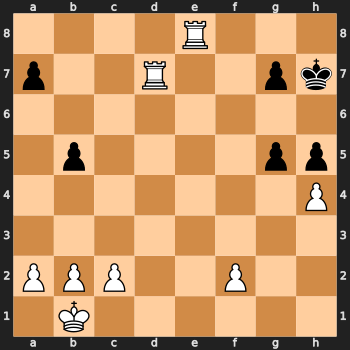

5rk1/r2n1ppB/2p1p3/p1Np2P1/2bP4/2P1P3/P2K1PP1/R6R b - - 0 20 Stockfish evaluation: 989
fen: 4R3/p2R2pk/8/1p4pp/7P/8/PPP2P2/1K6 w - - 12 37, Model evaluation: [721.16021899]


KeyboardInterrupt: 

In [713]:
engine = chess.engine.SimpleEngine.popen_uci("datasets/chess/stockfish.exe")
threshold = 200
# Your evaluation function
def evaluate_board(board):
    feature_vector = generate_feature_vector(board)
    return model.predict(feature_vector.reshape(1, -1))
    # score = get_stockfish_eval(board.fen())
    
    # return score

# Alpha-Beta pruning with evaluation threshold
def minimax(board, depth, alpha, beta, maximizing, threshold):
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)
    
    if maximizing:
        max_eval = float('-inf')
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth-1, alpha, beta, False, threshold)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = float('inf')
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth-1, alpha, beta, True, threshold)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

# Find the best move using minimax with alpha-beta pruning and evaluation threshold
def get_best_move(board, depth):
    if board.turn == chess.WHITE:  # If it's white's turn
        best_eval = float('-inf')
        maximizing = True
    else:  # If it's black's turn
        best_eval = float('inf')
        maximizing = False

    best_move = None
    for move in board.legal_moves:
        board.push(move)
        move_eval = minimax(board, depth-1, float('-inf'), float('inf'), not maximizing, threshold)
        board.pop()
        
        if maximizing and move_eval > best_eval:
            best_eval = move_eval
            best_move = move
        elif not maximizing and move_eval < best_eval:
            best_eval = move_eval
            best_move = move

    return best_move

# Initialize 
depth = 3
threshold = 100  # You can set this to the value that you consider a "won" or "lost" game
num_moves = 200

# Initialize an empty PGN
game = chess.pgn.Game()
# Initialize board
board = chess.Board()
# Create a node to represent the game's starting position
node = game.add_variation(chess.Move.from_uci("0000"))
# Play num_moves moves
for i in range(num_moves):
    if board.is_game_over():
        break
    best_move = get_best_move(board=board, depth=depth)
    board.push(best_move)
    node = node.add_variation(best_move)

    # Clear output
    clear_output(wait=True)
    # Display the board
    display(SVG(chess.svg.board(board=board, size=350)))
    print(f'{fen} Stockfish evaluation: {get_stockfish_eval(board.fen())}')

    print(f'fen: {board.fen()}, Model evaluation: {model.predict(generate_feature_vector(board).reshape(1, -1))}')
    time.sleep(0.1)

engine.quit()
exporter = chess.pgn.StringExporter()
pgn_string = game.accept(exporter)


print("PGN of the game:")
print(pgn_string)
